In [1]:
%matplotlib widget

In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace, divergence
from scipy.stats.qmc import Sobol
from pinns.interpolate import shape_function

In [3]:
domain = Hypercube((-0.5, -0.5, -0.5), (0.5, 0.5, 0.5))
x_dom = array(Sobol(3, seed=0).random_base2(12))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(2, seed=1).random_base2(11))
x_bnd = domain.transform_bnd(x_bnd)

_x_bnd = array(Sobol(2, seed=5).random_base2(8))
_x_bnd = domain.transform_bnd(_x_bnd)
x1 = [_x_bnd[_x_bnd[:, i] == -0.5, :] for i in range(3)]
x2 = [_x_bnd[_x_bnd[:, i] == 0.5, :] for i in range(3)]
shape_fun = shape_function(x1, x2)

def unit_vec(x):
    return x / norm(x, axis=-1, keepdims=True)

In [5]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_result(sol, ax, axis):
    plt.sca(ax)
    N = 200
    x = np.linspace(-1/2, 1/2, N)
    z = np.linspace(-1/2, 1/2, N)

    X = np.array([_x for _x in itertools.product(x, z)])
    _X = jnp.asarray(X)
    _X = jnp.insert(_X, array([axis]), zeros((N * N, 1)), 1)
    phi = np.array(sol(_X))

    p = ax.contourf(x, z, phi.reshape(N, N).T, 20, cmap=plt.get_cmap("YlOrRd"), alpha=0.5)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(p, cax=cax)


In [6]:
m_const = lambda x: array([0., 0., 1.])

def m_vortex(x):
    x, y, z = x[..., 0], x[..., 1], x[..., 2]
    rc = 0.14
    r = sqrt(x ** 2 + y ** 2)
    k = r**2 / rc**2
    mx = - y / r * sqrt(1 - exp(-4*k))
    my = x / r * sqrt(1 - exp(-4*k))
    mz = exp(-2*k)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

def m_flower(x):
    mx = x[..., 0] * x[..., 2]
    my = x[..., 1] * x[..., 2] + x[..., 1] ** 3 * x[..., 2] ** 3
    mz = ones_like(my)
    mag = stack([mx, my, mz], axis=-1)
    return unit_vec(mag)

weights = array(Sobol(4, seed=13).random_base2(8))
W_elm = (weights[:, :3] * 2 - 1) * 4
b_elm = (weights[:, 3] * 2 - 1) * 4

_x_bnd = array(Sobol(2, seed=134).random_base2(14))
_x_bnd = domain.transform_bnd(_x_bnd)

def phi2_solution(x, x_bnd, phi1, shape_fun, m):
    eps = 1e-9

    def g(y):
        n = unit_vec(-grad(shape_fun)(y))
        return dot(m(y), n) - dot(grad(phi1)(y), n)

    dist = vmap(lambda x: norm(x - x_bnd, axis=-1))(x)
    _g = vmap(g)(x_bnd)

    def kernel(dist):
        idx = dist > eps
        newton_kernel = where(idx, 1 / dist, 0.)
        N = jnp.count_nonzero(idx)
        return 6 / (4 * pi * N) * dot(newton_kernel, _g)

    return vmap(kernel)(dist)

h_elm = lambda x: tanh(W_elm @ x + b_elm)
u_elm = lambda x: shape_fun(x) * h_elm(x)
Q_elm = vmap(lambda x: -laplace(u_elm)(x))(x_dom)
U_elm, S_elm, VT_elm = jax.scipy.linalg.svd(Q_elm, full_matrices=False, lapack_driver="gesvd")
H_bnd_elm = vmap(h_elm)(x_bnd)
U_bnd_elm, S_bnd_elm, VT_bnd_elm = jax.scipy.linalg.svd(H_bnd_elm, full_matrices=False, lapack_driver="gesvd")

def solve_stray_field(m):
    f = lambda x: -divergence(m)(x)
    b1 = vmap(f)(x_dom)
    params_phi1 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b1))
    phi1 = lambda x: u_elm(x) @ params_phi1
    phi_bnd = phi2_solution(x_bnd, _x_bnd, phi1, shape_fun, m)
    params_phi_bnd = VT_bnd_elm.T @ ((1 / S_bnd_elm) * (U_bnd_elm.T @ phi_bnd))
    g2 = lambda x: h_elm(x) @ params_phi_bnd
    b2 = vmap(laplace(g2))(x_dom)
    params_phi2 = VT_elm.T @ ((1 / S_elm) * (U_elm.T @ b2))
    phi2 = lambda x: u_elm(x) @ params_phi2 + g2(x)
    phi_nn = lambda x: phi1(x) + phi2(x)
    return phi_nn


In [7]:
phi_const = solve_stray_field(m_const)
phi_flower = solve_stray_field(m_flower)
phi_vortex = solve_stray_field(m_vortex)

In [8]:
def ed(model, mag, x):
    H = lambda x: -grad(model)(x)
    e = lambda x: dot(mag(x), H(x)) 
    return -mean(vmap(e)(x)) / 2

In [9]:
print(f"energy for const mag {2 * ed(phi_const, m_const, x_dom):.4}")
print(f"energy for flower {2 * ed(phi_flower, m_flower, x_dom):.4}")
print(f"energy for vortex {2 * ed(phi_vortex, m_vortex, x_dom):.4}")

energy for const mag 0.3327
energy for flower 0.3052
energy for vortex 0.04363


In [10]:
from itertools import combinations, product

font = {'family' : 'serif',
    'serif': 'helvet',
    'weight' : 'bold',
    'size' : 12
}

plt.rc('font', **font)
plt.rc('text', usetex=True)

def plot_quiver(model, ax, length):
    X = jnp.meshgrid(np.arange(-1/2, 1/2+0.01, 0.2),
                    np.arange(-1/2, 1/2+0.01, 0.2),
                    np.arange(-1/2, 1/2+0.01, 0.2))

    X = jnp.stack(X, axis=-1)
    M = model(X)
    r1 = [-1/2, 1/2]
    r2 = [-1/2, 1/2]
    r3 = [-1/2, 1/2]
    for s, e in combinations(np.array(list(product(r1, r2, r3))), 2):
        if not (
            np.sum(np.abs(s-e)) < 1.0 or np.sum(np.abs(s-e)) > 1.01
            ):
            
            ax.plot3D(*zip(s, e), color="green")

    #ax.set_box_aspect((10, 10, 10))
    ax.quiver(
        X[..., 0], 
        X[..., 1], 
        X[..., 2], 
        M[..., 0], 
        M[..., 1], 
        M[..., 2], 
        length=length)
    ax.axis('off')

In [11]:
def stray_field(model):
    h = lambda x: -grad(model)(x)
    def _apply(X):
        _X = X.reshape(-1, 3)
        _h = vmap(h)(_X)
        _h = _h.reshape(*X.shape)
        return _h
    return _apply

def make_plots(m, phi, name=None, axis=1):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1,1,1, projection='3d')
    plot_quiver(m, ax, 0.1)
    if name is not None:
        fig.savefig(f"m_{name}.pdf")

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(1,1,1)
    plot_result(vmap(phi), ax, axis)
    ax.axis('off')
    ax.set_aspect('equal', 'box')
    fig.tight_layout()
    if name is not None:
        fig.savefig(f"phi_{name}.pdf")


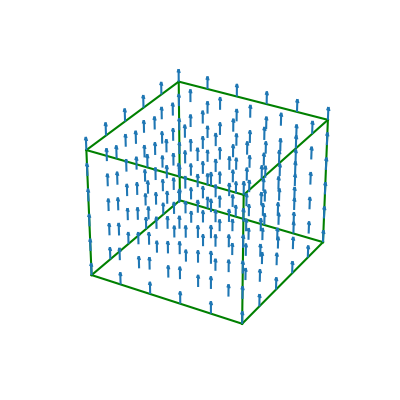

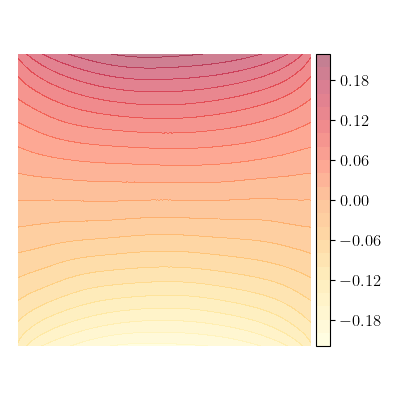

In [12]:
make_plots(m_const, phi_const, "const", 1)

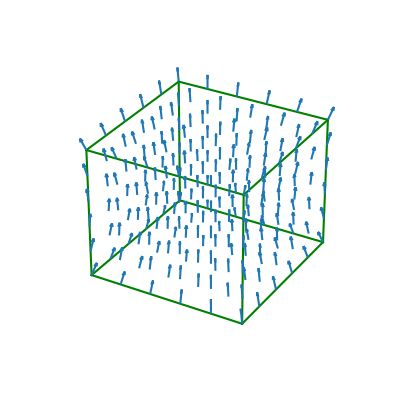

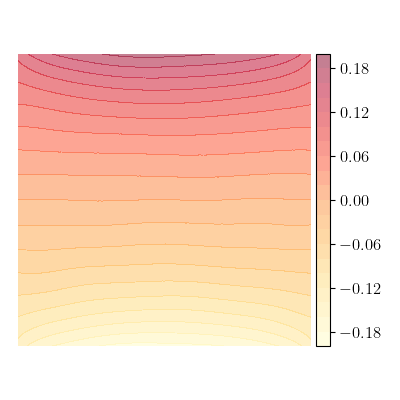

In [13]:
make_plots(m_flower, phi_flower, "flower", 1)

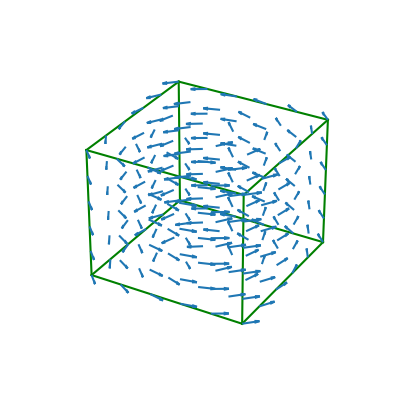

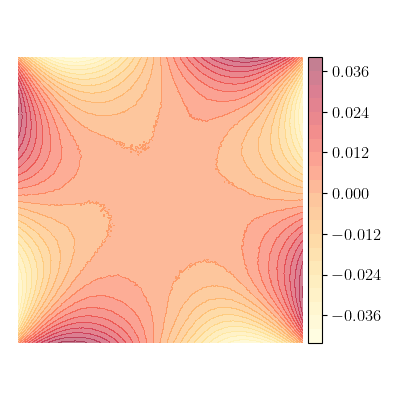

In [14]:
make_plots(m_vortex, phi_vortex, "vortex", 2)